# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [24]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [25]:
# Add any additional import statements you need here




In [26]:
# change `data_location` to the location of the folder on your machine.
data_location = "./"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [27]:
# Read in the lyrics data
# Construct the path to the lyrics folder
lyrics_path = os.path.join(data_location, lyrics_folder)

# Dictionary to hold lyrics data
# Structure: {artist: {song: lyrics_text}}
lyrics_data = {}

# Walk through all subfolders (each artist) and text files (each song)
for artist in os.listdir(lyrics_path):
    artist_folder = os.path.join(lyrics_path, artist)
    if os.path.isdir(artist_folder):
        lyrics_data[artist] = {}
        for song_file in os.listdir(artist_folder):
            if song_file.endswith(".txt"):
                song_path = os.path.join(artist_folder, song_file)
                with open(song_path, "r", encoding="utf-8") as f:
                    lyrics_data[artist][song_file.replace(".txt", "")] = f.read()

In [28]:
# Read in the twitter data
# Construct the path to the twitter folder
twitter_path = os.path.join(data_location, twitter_folder)

# Dictionary to hold Twitter data
# Structure: {artist: [list of tweet/description texts]}
twitter_data = {}

for artist in os.listdir(twitter_path):
    artist_folder = os.path.join(twitter_path, artist)
    if os.path.isdir(artist_folder):
        twitter_data[artist] = []
        for file in os.listdir(artist_folder):
            file_path = os.path.join(artist_folder, file)
            if file.endswith(".txt"):
                with open(file_path, "r", encoding="utf-8") as f:
                    twitter_data[artist].append(f.read().strip())
            elif file.endswith(".json"):
                # Handle JSON files if they exist
                with open(file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    # assuming each JSON has a 'description' field
                    if isinstance(data, dict) and "description" in data:
                        twitter_data[artist].append(data["description"])

In [29]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
# Construct file paths
positive_path = os.path.join(data_location, positive_words_file)
negative_path = os.path.join(data_location, negative_words_file)
tidytext_path = os.path.join(data_location, tidy_text_file)

# Read positive words
with open(positive_path, "r", encoding="utf-8", errors="ignore") as f:
    positive_words = [w.strip() for w in f if w.strip() and not w.startswith(";")]

# Read negative words
with open(negative_path, "r", encoding="utf-8", errors="ignore") as f:
    negative_words = [w.strip() for w in f if w.strip() and not w.startswith(";")]

# Create a sentiment dictionary
sentiment_dict = {}

for word in positive_words:
    sentiment_dict[word] = 1
for word in negative_words:
    sentiment_dict[word] = -1

# Optional: also read in the tidytext sentiment file if it exists
if os.path.exists(tidytext_path):
    tidy_df = pd.read_csv(tidytext_path, sep="\t", header=None, names=["word", "sentiment"])
    tidy_df["score"] = tidy_df["sentiment"].map({"positive": 1, "negative": -1})
else:
    tidy_df = pd.DataFrame(columns=["word", "sentiment", "score"])

print(f"Loaded {len(positive_words)} positive words and {len(negative_words)} negative words.")
print(f"Total words in sentiment dictionary: {len(sentiment_dict)}")
print(f"Tidytext entries: {len(tidy_df)}")

Loaded 2006 positive words and 4783 negative words.
Total words in sentiment dictionary: 6786
Tidytext entries: 15134


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [30]:
# your code here
# Function to clean and score text using sentiment_dict
def score_sentiment(text, sentiment_dict):
    # Lowercase and tokenize
    words = re.findall(r'\b[a-z]+\b', text.lower())
    
    # Score each word
    scores = [sentiment_dict.get(word, 0) for word in words]
    
    # Return average sentiment or 0 if no words scored
    if scores:
        return sum(scores) / len(scores)
    else:
        return 0

# Store sentiment results
song_sentiments = []

for artist, songs in lyrics_data.items():
    for song_title, lyrics in songs.items():
        sentiment_score = score_sentiment(lyrics, sentiment_dict)
        song_sentiments.append({
            "artist": artist,
            "song": song_title,
            "sentiment_score": sentiment_score
        })

# Convert to DataFrame for easy analysis
song_sentiments_df = pd.DataFrame(song_sentiments)

# Display results
print(song_sentiments_df.head())
print("\nAverage sentiment by artist:")
print(song_sentiments_df.groupby("artist")["sentiment_score"].mean())

  artist                           song  sentiment_score
0   cher                 cher_88degrees         0.008798
1   cher  cher_adifferentkindoflovesong         0.066406
2   cher                  cher_afterall        -0.003257
3   cher                     cher_again         0.023810
4   cher                     cher_alfie         0.048951

Average sentiment by artist:
artist
cher     0.015965
robyn    0.011234
Name: sentiment_score, dtype: float64


In [31]:
song_sentiments_df.groupby("artist")["sentiment_score"].mean()

artist
cher     0.015965
robyn    0.011234
Name: sentiment_score, dtype: float64

In [32]:
# Find top and bottom 3 songs for each artist
for artist in song_sentiments_df["artist"].unique():
    artist_songs = song_sentiments_df[song_sentiments_df["artist"] == artist]
    
    print(f"\n=== {artist.upper()} ===")
    print("Top 3 most positive songs:")
    top3 = artist_songs.sort_values("sentiment_score", ascending=False).head(3)
    print(top3[["song", "sentiment_score"]])
    
    print("\nBottom 3 most negative songs:")
    bottom3 = artist_songs.sort_values("sentiment_score", ascending=True).head(3)
    print(bottom3[["song", "sentiment_score"]])
    
    # Optional: print the lyrics of those songs
    print("\n--- Example lyrics from most positive song ---")
    song_name = top3.iloc[0]["song"]
    print(lyrics_data[artist][song_name][:500], "...\n")  # print first 500 chars



=== CHER ===
Top 3 most positive songs:
                          song  sentiment_score
181                cher_mylove         0.246073
179                cher_moveme         0.174194
155  cher_loveandunderstanding         0.150171

Bottom 3 most negative songs:
                             song  sentiment_score
42          cher_crymyselftosleep        -0.107692
196               cher_outrageous        -0.090226
133  cher_iwalkonguildedsplinters        -0.082508

--- Example lyrics from most positive song ---
"My Love"



When I go away
I know my heart can stay with my love
It's understood
Everywhere with my love
My love does it good, whoa
My love, oh only my love
My love does it good

And when the cupboard's bare
I'll still find something there with my love
It's understood
Everywhere with my love
My love does it so good, whoa
My love, oh only my love
My love does it good

Only my love, oh only my love
Only my love, hold the other things to me
Oh, only my love, oh only my love
Only my

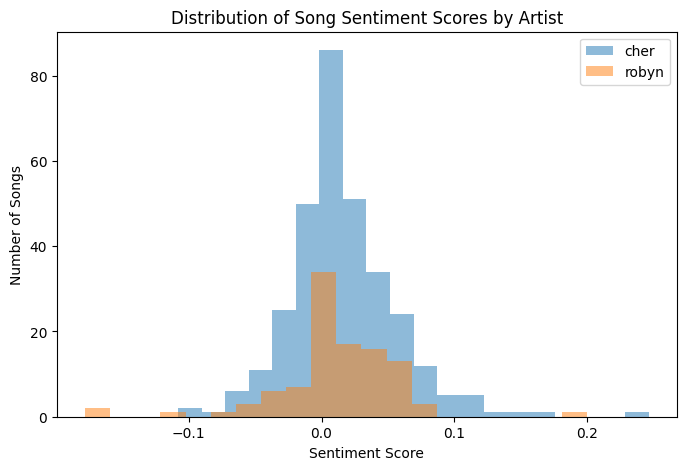

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for artist in song_sentiments_df["artist"].unique():
    plt.hist(
        song_sentiments_df[song_sentiments_df["artist"] == artist]["sentiment_score"],
        bins=20, alpha=0.5, label=artist
    )

plt.xlabel("Sentiment Score")
plt.ylabel("Number of Songs")
plt.title("Distribution of Song Sentiment Scores by Artist")
plt.legend()
plt.show()


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Cher has the higher average sentiment: 0.015965 for Cher vs 0.011234 for Robyn, so Cher’s catalog is (slightly) more positive on average.

---

Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Highest: “cher_mylove” (0.2461), “cher_moveme” (0.1742), “cher_loveandunderstanding” (0.1502). Lowest: “cher_crymyselftosleep” (−0.1077), “cher_outrageous” (−0.0902), “cher_iwalkonguildedsplinters” (−0.0825). The highs are packed with strongly positive cue words repeated throughout—e.g., love, free, move, understanding, good—so the lexicon adds many +1s. The lows lean on negative terms like cry, sleep (in sad contexts), outrageous, splinters, fall, hurt, which accumulate −1s. Repetition (choruses) and the bag-of-words nature of the method amplify these effects and ignore context/negation.

---

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: Highest: “robyn_loveisfree” (0.2000), “robyn_babyforgiveme” (0.0795), “robyn_doyoureallywantmeshowrespect” (0.0733). Lowest: “robyn_dontfuckingtellmewhattodo114520” (−0.1778), “robyn_dontfuckingtellmewhattodo” (−0.1778), “robyn_criminalintent” (−0.1128). Positives are driven by heavy repetition of words like love, free, baby, forgive, respect. Negatives feature many negative/command/profanity tokens and crime-related terms—don’t, tell, fucking, wrong, criminal, intent—which the lexicon scores as −1; repetition pushes those songs further left.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

A: Both artists’ histograms are centered near 0 with heavy overlap, indicating many mixed-tone songs. Cher’s distribution sits slightly right of Robyn’s (consistent with the higher mean) and shows a longer positive tail reaching about 0.25 (e.g., “My Love”). Robyn shows a few strong negative outliers around −0.18 to −0.20 (the don’t tell me what to do tracks) and a shorter positive tail topping near 0.20. Overall differences are modest, and shape/spread reflect chorus repetition and lexicon limits (no handling of negation, sarcasm, or context).




## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [41]:
import os

twitter_path = os.path.join(data_location, twitter_folder)
twitter_data = {}

# Loop through all .txt files in the twitter folder
for file in os.listdir(twitter_path):
    if file.endswith(".txt") and not file.startswith("."):  # ignore .DS_Store
        artist = file.split("_followers")[0]  # extract artist name before "_followers"
        file_path = os.path.join(twitter_path, file)
        
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
            twitter_data[artist] = [line.strip() for line in lines if line.strip()]

print(f"Loaded Twitter data for {len(twitter_data)} artists.")
for artist, descs in twitter_data.items():
    print(f"{artist}: {len(descs)} lines loaded")



Loaded Twitter data for 2 artists.
cher: 3994804 lines loaded
robynkonichiwa: 358373 lines loaded


In [42]:
# --- Step 1: Define emoji sets ---
positive_emojis = ['😀', '😃', '😄', '😁', '😊', '😍', '🥰', '🤩', '😇', '❤️', '👍', '💖', '✨', '🥳', '😎']
negative_emojis = ['😢', '😭', '😞', '😔', '😠', '😡', '🤬', '💔', '😫', '😩', '😤', '👎', '☹️', '🙁', '😖']

emoji_sentiment = {e: 1 for e in positive_emojis}
emoji_sentiment.update({e: -1 for e in negative_emojis})

# --- Step 2: Function to score emojis in text ---
def emoji_score(text):
    if not isinstance(text, str):  # Handle non-string cases
        text = str(text)
    score = 0
    count = 0
    for ch in text:
        if ch in emoji_sentiment:
            score += emoji_sentiment[ch]
            count += 1
    return score, count

# --- Step 3: Calculate emoji sentiment per artist ---
twitter_results = []

for artist, descriptions in twitter_data.items():
    total_score = 0
    total_emojis = 0
    for desc in descriptions:
        # Handle if description is a dict with "description" key
        if isinstance(desc, dict) and "description" in desc:
            text = desc["description"]
        else:
            text = str(desc)
        s, c = emoji_score(text)
        total_score += s
        total_emojis += c
    
    avg_sentiment = total_score / total_emojis if total_emojis > 0 else 0
    twitter_results.append({
        "artist": artist,
        "avg_emoji_sentiment": avg_sentiment,
        "total_emojis": total_emojis
    })

# --- Step 4: Create DataFrame and display ---
import pandas as pd
twitter_sentiment_df = pd.DataFrame(twitter_results)
print(twitter_sentiment_df)


           artist  avg_emoji_sentiment  total_emojis
0            cher             0.885657        102604
1  robynkonichiwa             0.920188          5538


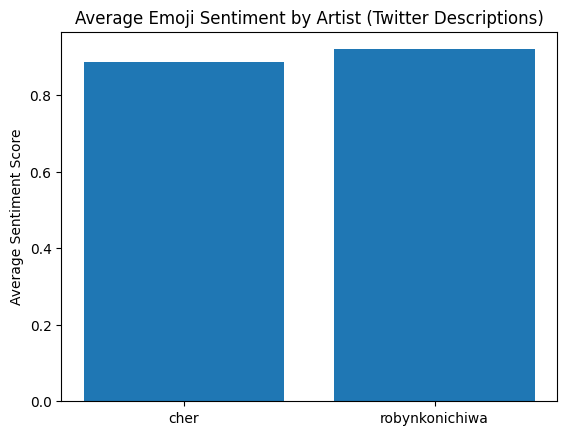

In [45]:
plt.bar(twitter_sentiment_df["artist"], twitter_sentiment_df["avg_emoji_sentiment"])
plt.title("Average Emoji Sentiment by Artist (Twitter Descriptions)")
plt.ylabel("Average Sentiment Score")
plt.show()

In [47]:
from collections import Counter

pos_set = set(positive_emojis)
neg_set = set(negative_emojis)

def top_emojis_for_artist(artist, texts):
    # count all tracked emojis for this artist
    counts = Counter(ch for t in texts for ch in str(t) if ch in emoji_sentiment)
    pos_counts = Counter({e: counts[e] for e in pos_set if counts[e] > 0})
    neg_counts = Counter({e: counts[e] for e in neg_set if counts[e] > 0})
    top_pos = pos_counts.most_common(1)[0] if pos_counts else ("(none)", 0)
    top_neg = neg_counts.most_common(1)[0] if neg_counts else ("(none)", 0)
    return top_pos, top_neg, pos_counts.most_common(5), neg_counts.most_common(5)

for artist, texts in twitter_data.items():
    top_pos, top_neg, top5_pos, top5_neg = top_emojis_for_artist(artist, texts)
    print(f"\n=== {artist} ===")
    print(f"Most popular positive: {top_pos[0]}  (count: {top_pos[1]})")
    print(f"Most popular negative: {top_neg[0]}  (count: {top_neg[1]})")
    print(f"Top 5 positives: {top5_pos}")
    print(f"Top 5 negatives: {top5_neg}")



=== cher ===
Most popular positive: ✨  (count: 45846)
Most popular negative: 💔  (count: 2001)
Top 5 positives: [('✨', 45846), ('💖', 11214), ('😍', 8955), ('😎', 6663), ('😊', 5202)]
Top 5 negatives: [('💔', 2001), ('😭', 823), ('🤬', 521), ('😔', 464), ('😩', 401)]

=== robynkonichiwa ===
Most popular positive: ✨  (count: 3217)
Most popular negative: 💔  (count: 72)
Top 5 positives: [('✨', 3217), ('💖', 531), ('😎', 325), ('😍', 288), ('😊', 206)]
Top 5 negatives: [('💔', 72), ('😭', 42), ('🤬', 22), ('😔', 15), ('😩', 14)]


Q: What is the average sentiment of your two artists? 

A: Cher’s followers have an average emoji sentiment score of 0.886, while Robyn’s followers (under the handle robynkonichiwa) average slightly higher at 0.920. Both communities show overwhelmingly positive emoji use, indicating that their followers’ bios and descriptions are strongly upbeat overall. The difference between the two is small, but Robyn’s followers express positivity a bit more consistently, while Cher’s much larger audience (over 100k emojis) includes a wider range of emotional tone.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For both artists, the sparkles emoji ✨ is the most common positive symbol, representing excitement, glamour, and celebration. Cher’s followers use it 45,846 times and Robyn’s followers 3,217 times.
The most frequent negative emoji for both is the broken heart 💔, appearing 2,001 times for Cher and 72 times for Robyn. This suggests that even when followers express negative sentiment, it tends to center around themes of emotional vulnerability rather than anger or hostility. Overall, both fanbases lean heavily toward using joyful, affectionate emojis — fitting for pop artists whose personas celebrate self-expression and empowerment.

